In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8187168954848004340
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10087235584
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12252961754619487178
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import os
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#needed for DNN 
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
# from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.preprocessing.text import Tokenizer
# from sklearn.utils import shuffle

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/drug review SA'

In [ ]:
df = pd.read_csv(PATH + '/data/results/clean_df.csv')
df = df.drop(['review','rating','vader_polarity', 'Review_Sentiment','blob_polarity', 'class_2' ], axis = 1)
df.head()

,cleaned_reviews,class
0,side effect take combination bystolic mg fish oil,neutral
1,son halfway fourth week intuniv become concern...,positve
2,use take another oral contraceptive pill cycle...,positve
3,first time use form birth control glad go patc...,positve
4,suboxone completely turn life around feel heal...,positve


In [ ]:
# label encoding for output

sample_data = [2000,3000,100,2004,3080,4020]

def label_encoding(category,bool):
  le = preprocessing.LabelEncoder()
  le.fit(category)
  encoded_labels = le.transform(category)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print("\n\t\t\t Label Encoding ","\nClass Names:-->",le.classes_)
    for i in sample_data:
      print(category[i],' ', encoded_labels[i],'\n')
    return labels

labels = label_encoding(df['class'],True)


			 Label Encoding  
Class Names:--> ['negative' 'neutral' 'positve']
positve   2 

negative   0 

negative   0 

positve   2 

negative   0 

negative   0 



In [ ]:
# set aside 20% of train and test data for evaluation
df.cleaned_reviews=df.cleaned_reviews.astype(str)

X = df.cleaned_reviews
Y = labels

def dataset_split(inputs, tags):

    X,X_test,y,y_test = train_test_split(inputs,tags,train_size = 0.9,
                                                  test_size = 0.1,random_state =42)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.95,
                                                  test_size = 0.05,random_state =42)
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(inputs),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test

X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(X,Y)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 215063 
	Training		 183878 
	Test			 21507 
	Validation		 9678


In [ ]:
# Train Data Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 100
vocab_size = 43000  

tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>",filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
tokenizer.fit_on_texts(X_train.values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Taining Data padding
train_sequences = tokenizer.texts_to_sequences(X_train.values)
train_padded = pad_sequences(train_sequences,padding='post', maxlen=max_length)

# Validation Data padding
validation_sequences = tokenizer.texts_to_sequences(X_valid.values)
validation_padded = pad_sequences(validation_sequences,padding='post', maxlen=max_length)

# testing data padding
test_sequences = tokenizer.texts_to_sequences(X_test.values)
test_padded = pad_sequences(test_sequences,padding='post',maxlen=max_length)

test_padded[0]

Found 42565 unique tokens.


array([ 1516, 34535,     1,   239,   740,     1,  3491,   293,   369,
         311,    14,   521,   160,   892,    27,  1439,   593,   389,
           8,  3841,   746,    36,     8,   844,    24,   989,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [ ]:
import nltk
from tqdm import tqdm
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
####
embedding_vector = {}
f = open('/content/drive/MyDrive/Colab Notebooks/CyberBullying Detection/glove file/glove.6B.300d.txt',encoding="utf8")
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:27, 14443.28it/s]
100%|██████████| 42565/42565 [00:00<00:00, 516822.22it/s]


In [ ]:
def padded_infos(original,encoded,padded):
  print("\n\t\t\t Encoded Sequences ","\n")  
  print(original,"\n",encoded) 
  print("\n\t\t\t Paded Sequences \n",original,"\n",padded)

padded_infos(X_train[1],train_sequences[1],train_padded[1])


			 Encoded Sequences  

son halfway fourth week intuniv become concerned begin last week start take high dose two day could hardly get bed cranky sleep nearly hour drive home school vacation unusual call doctor monday morning say stick day see school get morning last two day problem free much agreeable ever less emotional good thing less cranky remembering thing overall behavior well try many different medication far effective 
 [135, 310, 48, 609, 72, 4, 569, 289, 237, 22, 38, 441, 12, 11, 606, 387, 62, 143, 20, 18, 99, 20, 206, 98, 103, 1156, 126, 117, 4752, 289, 293, 2, 2, 19, 2, 472, 705, 1587, 230, 4, 153, 310, 237, 4, 71, 31, 145, 1073, 38, 4752, 289, 17, 30, 5, 33, 57, 140, 20, 59]

			 Paded Sequences 
 son halfway fourth week intuniv become concerned begin last week start take high dose two day could hardly get bed cranky sleep nearly hour drive home school vacation unusual call doctor monday morning say stick day see school get morning last two day problem free much agreeab

In [ ]:
#confusion matrix
def conf_matrix(y_pred):
  cm = confusion_matrix(y_test, y_pred) 

  cm_df = pd.DataFrame(cm,
                       index = ['negative', 'Neutral', 'Positive'], 
                       columns = ['negative', 'Neutral', 'Positive'])
  sns.set(font_scale=2) 
  plt.figure(figsize=(10,8))
  sns.heatmap(cm_df, annot=True,cmap="coolwarm", fmt='g')
  plt.ylabel('True label',fontsize=20)
  plt.xlabel('Predicted label',fontsize=20)
  plt.xticks( rotation=90, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.show()
  plt.close()

In [ ]:
accuracy_threshold = 0.999
from tensorflow import keras
keras.backend.clear_session()
#callback function for early stopping
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()


In [ ]:
embedding_dim=300
num_category = 3
epochs = 100
batch = 128
opt=RMSprop(0.001)


In [ ]:
def Bidirectional_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer=opt , 
                                   p_loss:str = 'sparse_categorical_crossentropy', p_metrics:list = ['accuracy']):
    """
    Build a Bidirectional Models for classification
    """
    filepath = PATH + '/models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint ]
    
    print('----------------------------- sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1],weights=[embedding_matrix], trainable=False),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Bidirectional(model_name(GRU_unit,return_sequences=True)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

In [ ]:
# Bidirection GRU 
BiGRU_model, BiGRU_history = Bidirectional_classifier_model(model_name = GRU,
                                                            file_name = 'glove_BiGRU.h5',
                                                            GRU_unit = 200,
                                                            epochs = epochs,
                                                            batch = batch)

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          12900000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 400)          602400    
_________________________________________________________________
dense (Dense)                (None, 100, 64)           25664     
_________________________________________________________________
dropout (Dropout)            (None, 100, 64)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 100, 32)           2080      
__________________________________

1437/1437 [==============================] - 82s 57ms/step - loss: 0.1511 - accuracy: 0.9552 - val_loss: 0.2628 - val_accuracy: 0.8972

Epoch 00066: val_accuracy did not improve from 0.95702
Epoch 67/100
1437/1437 [==============================] - 83s 58ms/step - loss: 0.1602 - accuracy: 0.9535 - val_loss: 0.2255 - val_accuracy: 0.9328

Epoch 00067: val_accuracy did not improve from 0.95702
Epoch 68/100
1437/1437 [==============================] - 82s 57ms/step - loss: 0.1553 - accuracy: 0.9544 - val_loss: 0.2441 - val_accuracy: 0.9496

Epoch 00068: val_accuracy did not improve from 0.95702
Epoch 69/100
1437/1437 [==============================] - 82s 57ms/step - loss: 0.1609 - accuracy: 0.9528 - val_loss: 0.2643 - val_accuracy: 0.9079

Epoch 00069: val_accuracy did not improve from 0.95702
Epoch 70/100
1437/1437 [==============================] - 82s 57ms/step - loss: 0.1583 - accuracy: 0.9535 - val_loss: 0.3180 - val_accuracy: 0.9051

Epoch 00070: val_accuracy did not improve from 0

In [ ]:
model_path = "/Ml files/drug review SA/models"

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

673/673 [==============================] - 15s 19ms/step - loss: 0.2430 - accuracy: 0.9522
loss 0.24301186203956604
Accuracy 0.9521551132202148
Precision 0.8858455593822585
Recall 0.8898324720231948
f1 score 0.8878082842958012


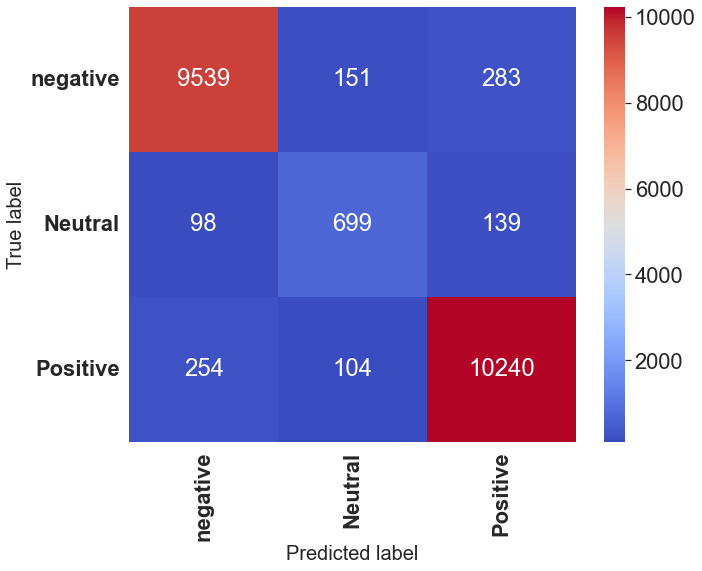

In [ ]:
#make predictions

model = load_model(model_path+"/glove_BiGRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

In [ ]:
#Report generation

def report_generate(pred,classifier):
  sns.set_style("whitegrid")
  report = pd.DataFrame(classification_report(y_true = y_test, y_pred =pred, output_dict=True)).transpose()
  report = report.rename(index={'0': 'negative','1':'Neutral','2':'Positive'})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)
  columns = ['precision','recall','f1-score']
  report.columns = columns
  plt = report.plot(kind='bar',figsize=(12,6))
  plt.set_title('Multi-class Classification Report for '+str(classifier)+' .', fontsize=20)
  plt.tick_params(axis='x',rotation=30,labelsize=25)
  plt.tick_params(axis='y',rotation=0,labelsize=25)
  plt.legend(['precision', 'recall', 'f1-score'], loc=2,bbox_to_anchor = (1,1), prop={'size': 20})
  plt.grid('white')
  return plt,report

,precision,recall,f1-score
negative,96.44,95.65,96.04
Neutral,73.27,74.68,73.97
Positive,96.04,96.62,96.33
accuracy,95.22,95.22,95.22
macro avg,88.58,88.98,88.78
weighted avg,95.24,95.22,95.22


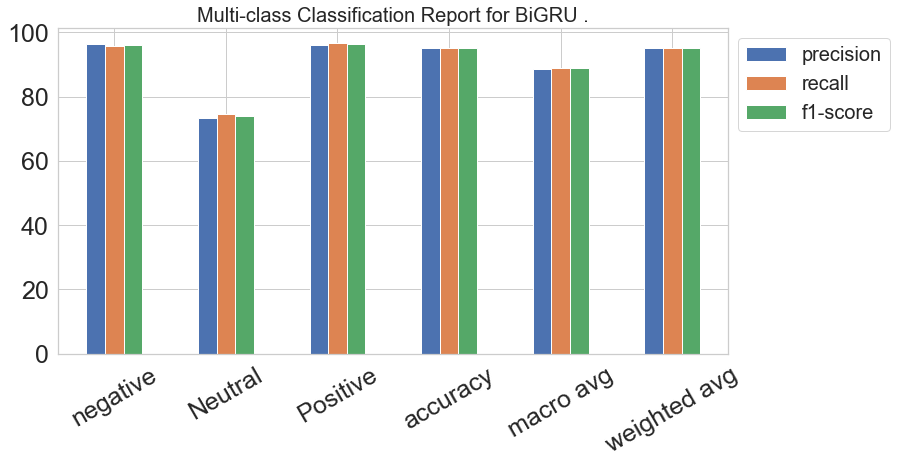

In [ ]:
GRUreport=report_generate(y_pred,"BiGRU")
GRUreport[1]

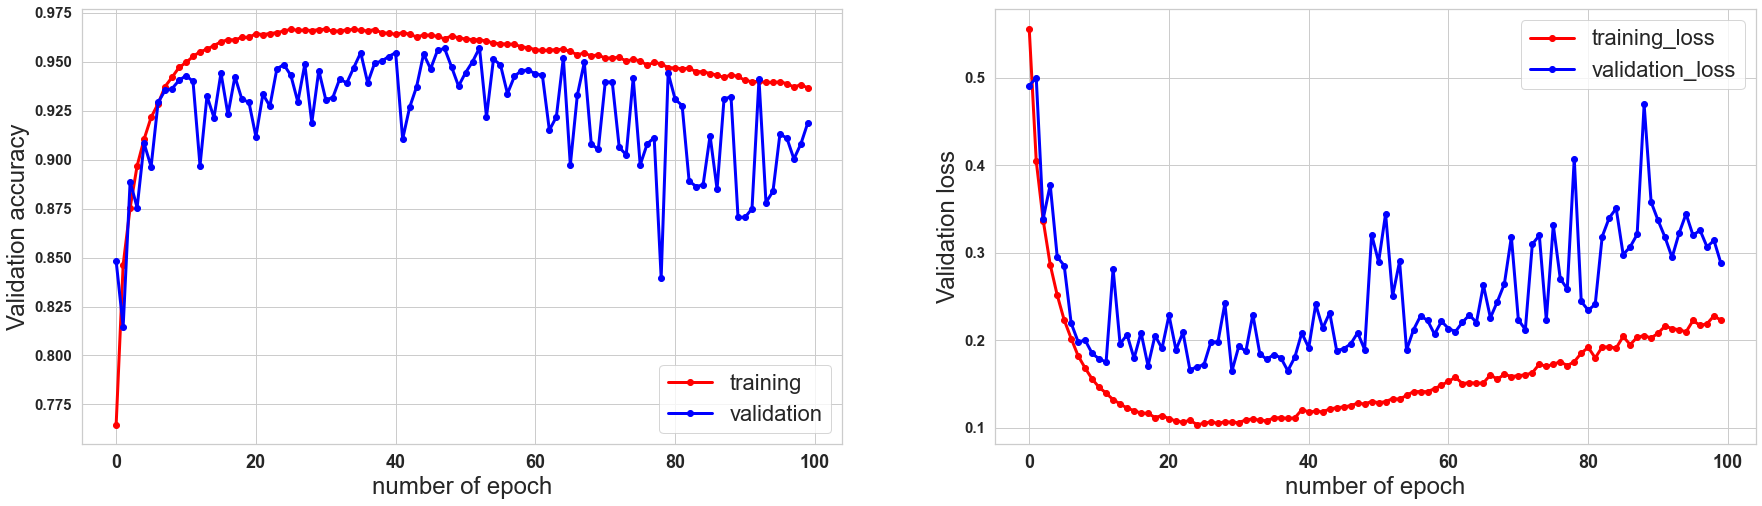

In [ ]:
def model_evaluate(history):
  sns.set_style("whitegrid")
  H = history.history
  fig = plt.figure(figsize = (30, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H['accuracy'], label = 'training', marker='o', color='red', linewidth=3 )
  plt.plot(H['val_accuracy'], label = 'validation', marker='o', color='blue', linewidth=3 )
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H['loss'], label = 'training_loss', marker='o', color='red', linewidth=3 )
  plt.plot(H['val_loss'], label = 'validation_loss', marker='o', color='blue', linewidth=3 )
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()
    
model_evaluate(BiGRU_history)

In [ ]:
BiLSTM_model, BiLSTM_history = Bidirectional_classifier_model(model_name = LSTM,
                                                            file_name = 'glove_BiLSTM.h5',
                                                            GRU_unit = 200,
                                                            epochs = epochs,
                                                            batch = batch)

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          12900000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 400)          801600    
_________________________________________________________________
dense_4 (Dense)              (None, 100, 64)           25664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 100, 32)           2080      
________________________________

1437/1437 [==============================] - 90s 63ms/step - loss: 0.0742 - accuracy: 0.9761 - val_loss: 0.1291 - val_accuracy: 0.9602

Epoch 00027: val_accuracy did not improve from 0.96477
Epoch 28/100
1437/1437 [==============================] - 91s 64ms/step - loss: 0.0752 - accuracy: 0.9759 - val_loss: 0.1573 - val_accuracy: 0.9583

Epoch 00028: val_accuracy did not improve from 0.96477
Epoch 29/100
1437/1437 [==============================] - 91s 64ms/step - loss: 0.0719 - accuracy: 0.9773 - val_loss: 0.1492 - val_accuracy: 0.9534

Epoch 00029: val_accuracy did not improve from 0.96477
Epoch 30/100
1437/1437 [==============================] - 91s 64ms/step - loss: 0.0745 - accuracy: 0.9766 - val_loss: 0.1816 - val_accuracy: 0.9378

Epoch 00030: val_accuracy did not improve from 0.96477
Epoch 31/100
1437/1437 [==============================] - 90s 62ms/step - loss: 0.0728 - accuracy: 0.9771 - val_loss: 0.1366 - val_accuracy: 0.9678

Epoch 00031: val_accuracy improved from 0.96477 

1437/1437 [==============================] - 90s 63ms/step - loss: 0.0610 - accuracy: 0.9826 - val_loss: 0.1901 - val_accuracy: 0.9704

Epoch 00066: val_accuracy did not improve from 0.97344
Epoch 67/100
1437/1437 [==============================] - 92s 64ms/step - loss: 0.0623 - accuracy: 0.9831 - val_loss: 0.1596 - val_accuracy: 0.9682

Epoch 00067: val_accuracy did not improve from 0.97344
Epoch 68/100
1437/1437 [==============================] - 92s 64ms/step - loss: 0.0601 - accuracy: 0.9829 - val_loss: 0.1770 - val_accuracy: 0.9760

Epoch 00068: val_accuracy improved from 0.97344 to 0.97603, saving model to /Ml files/drug review SA/models\glove_BiLSTM.h5
Epoch 69/100
1437/1437 [==============================] - 92s 64ms/step - loss: 0.0646 - accuracy: 0.9838 - val_loss: 0.1574 - val_accuracy: 0.9655

Epoch 00069: val_accuracy did not improve from 0.97603
Epoch 70/100
1437/1437 [==============================] - 92s 64ms/step - loss: 0.0596 - accuracy: 0.9836 - val_loss: 0.1520 - v

673/673 [==============================] - 18s 25ms/step - loss: 0.1970 - accuracy: 0.9741
loss 0.19704528152942657
Accuracy 0.9740549325942993
Precision 0.9354946138021084
Recall 0.9414593617288153
f1 score 0.9384378661126792


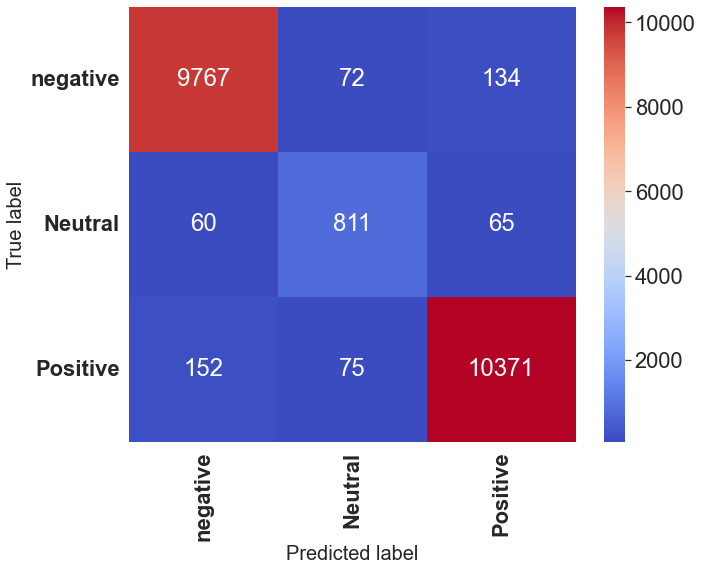

In [ ]:
#make predictions
model = load_model(model_path+"/glove_BiLSTM.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

,precision,recall,f1-score
negative,97.88,97.93,97.90
Neutral,84.66,86.65,85.64
Positive,98.12,97.86,97.99
accuracy,97.41,97.41,97.41
macro avg,93.55,94.15,93.84
weighted avg,97.42,97.41,97.41


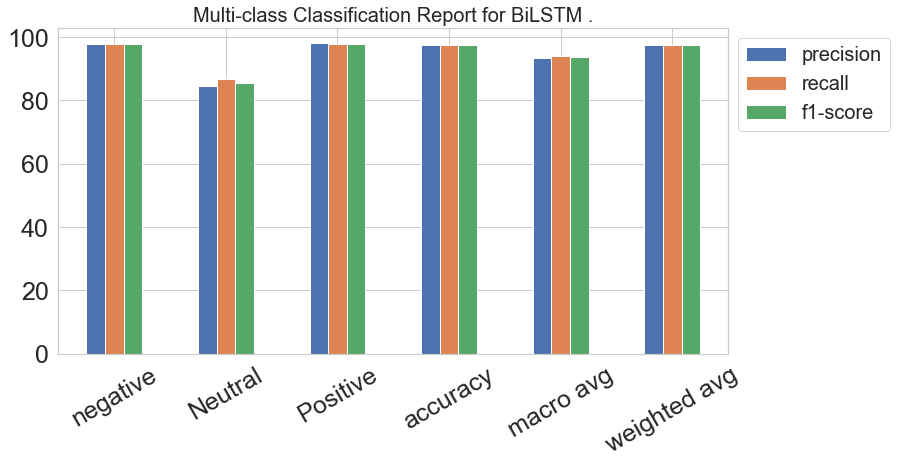

In [ ]:
BiLSTMreport=report_generate(y_pred,"BiLSTM")
BiLSTMreport[1]

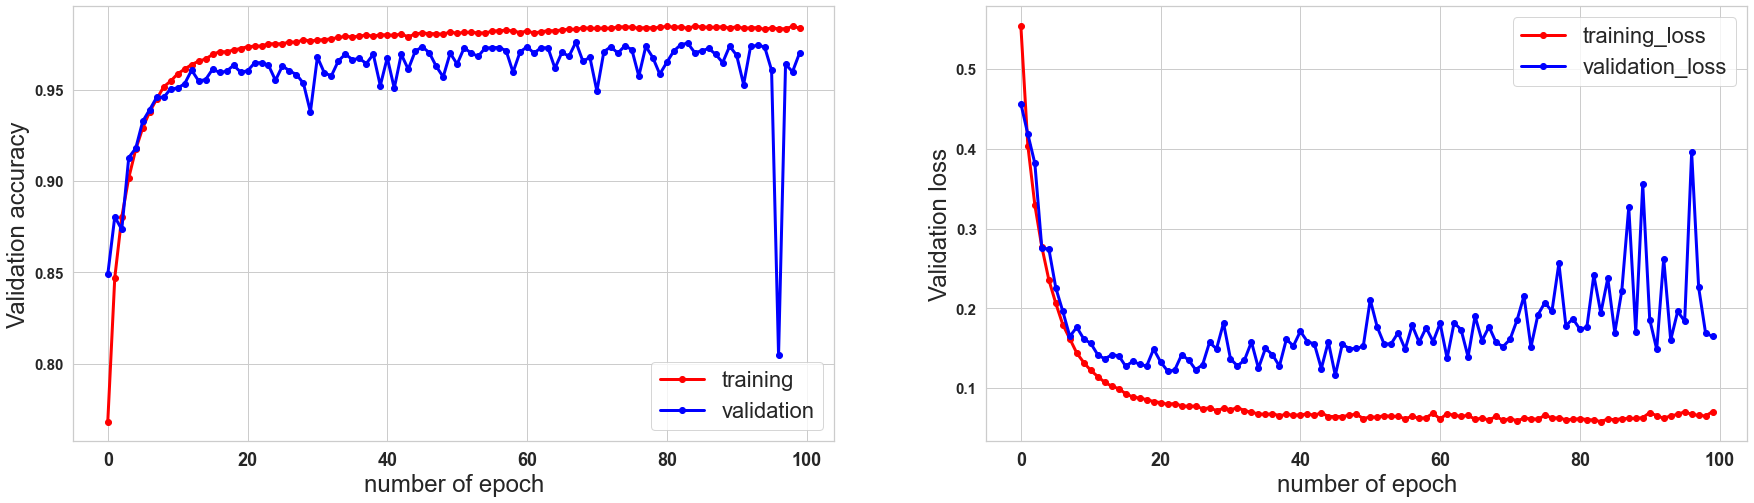

In [ ]:
model_evaluate(BiLSTM_history)

In [ ]:
def directional_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer= opt , 
                                   p_loss:str = 'sparse_categorical_crossentropy', p_metrics:list = ['accuracy']):
    """
    Build a directional Models for classification
    """
    filepath = PATH+ '/models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint]
    
    print('----------------------------- sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1],weights=[embedding_matrix], trainable=False),
        tf.keras.layers.SpatialDropout1D(0.2),
        model_name(GRU_unit,return_sequences=True),
#         model_name(128, dropout = 0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

In [ ]:
LSTM_model, LSTM_history =directional_classifier_model(model_name = LSTM,
                                                            file_name = 'glove_LSTM.h5',
                                                            GRU_unit = 200,
                                                            epochs = epochs,
                                                            batch = batch)


----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          12900000  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 200)          400800    
_________________________________________________________________
dense_8 (Dense)              (None, 100, 64)           12864     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 100, 32)           2080      
________________________________

1437/1437 [==============================] - 54s 38ms/step - loss: 0.0862 - accuracy: 0.9713 - val_loss: 0.1344 - val_accuracy: 0.9652

Epoch 00027: val_accuracy improved from 0.96260 to 0.96518, saving model to /Ml files/drug review SA/models\glove_LSTM.h5
Epoch 28/100
1437/1437 [==============================] - 55s 38ms/step - loss: 0.0859 - accuracy: 0.9720 - val_loss: 0.1283 - val_accuracy: 0.9594

Epoch 00028: val_accuracy did not improve from 0.96518
Epoch 29/100
1437/1437 [==============================] - 54s 38ms/step - loss: 0.0850 - accuracy: 0.9718 - val_loss: 0.1283 - val_accuracy: 0.9666

Epoch 00029: val_accuracy improved from 0.96518 to 0.96663, saving model to /Ml files/drug review SA/models\glove_LSTM.h5
Epoch 30/100
1437/1437 [==============================] - 54s 38ms/step - loss: 0.0853 - accuracy: 0.9715 - val_loss: 0.1449 - val_accuracy: 0.9634

Epoch 00030: val_accuracy did not improve from 0.96663
Epoch 31/100
1437/1437 [==============================] - 59s 4

1437/1437 [==============================] - 51s 36ms/step - loss: 0.0742 - accuracy: 0.9765 - val_loss: 0.1936 - val_accuracy: 0.9660

Epoch 00066: val_accuracy did not improve from 0.96911
Epoch 67/100
1437/1437 [==============================] - 53s 37ms/step - loss: 0.0749 - accuracy: 0.9771 - val_loss: 0.1650 - val_accuracy: 0.9638

Epoch 00067: val_accuracy did not improve from 0.96911
Epoch 68/100
1437/1437 [==============================] - 51s 36ms/step - loss: 0.0771 - accuracy: 0.9757 - val_loss: 0.1591 - val_accuracy: 0.9672

Epoch 00068: val_accuracy did not improve from 0.96911
Epoch 69/100
1437/1437 [==============================] - 51s 36ms/step - loss: 0.0764 - accuracy: 0.9762 - val_loss: 0.1818 - val_accuracy: 0.9648

Epoch 00069: val_accuracy did not improve from 0.96911
Epoch 70/100
1437/1437 [==============================] - 51s 36ms/step - loss: 0.0769 - accuracy: 0.9762 - val_loss: 0.1630 - val_accuracy: 0.9668

Epoch 00070: val_accuracy did not improve from 0

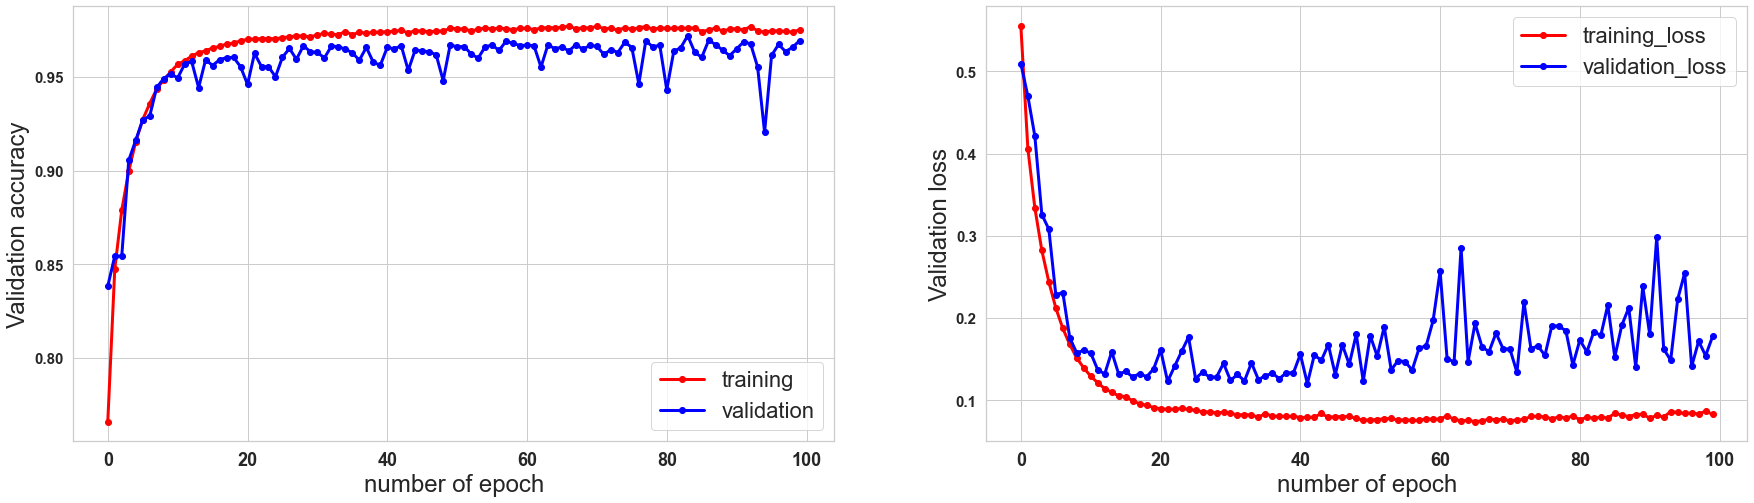

In [ ]:
model_evaluate(LSTM_history)

673/673 [==============================] - 14s 17ms/step - loss: 0.1589 - accuracy: 0.9721
loss 0.1589415818452835
Accuracy 0.9720556139945984
Precision 0.9460400142386675
Recall 0.9005224381528546
f1 score 0.9209070931278865


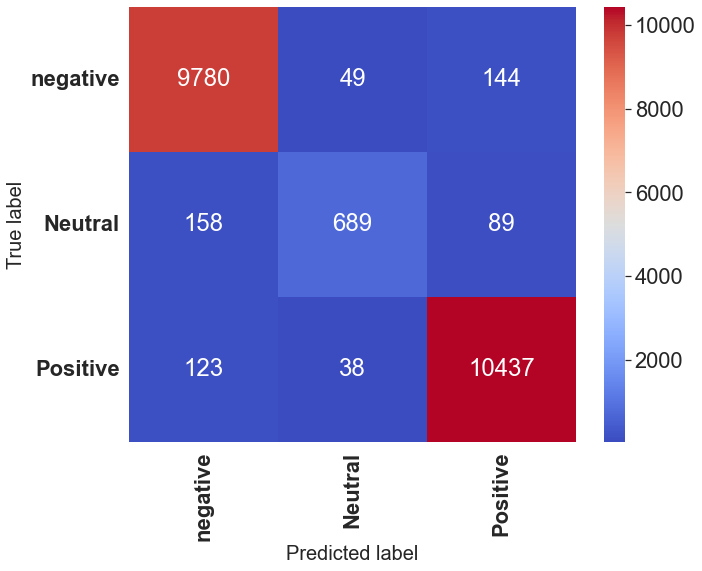

In [ ]:
#make predictions
model = load_model(model_path+"/glove_LSTM.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

,precision,recall,f1-score
negative,97.21,98.06,97.63
Neutral,88.79,73.61,80.49
Positive,97.82,98.48,98.15
accuracy,97.21,97.21,97.21
macro avg,94.60,90.05,92.09
weighted avg,97.14,97.21,97.14


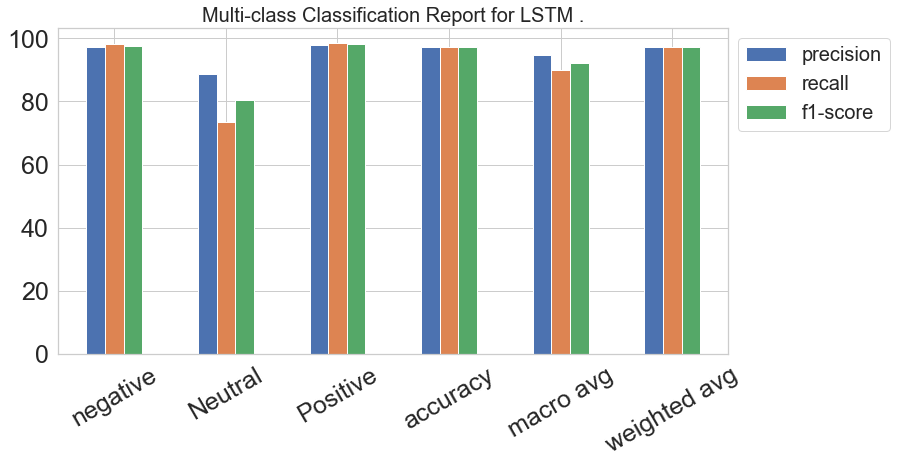

In [ ]:
LSTMreport=report_generate(y_pred,"LSTM")
LSTMreport[1]

In [ ]:
GRU_model, GRU_history =directional_classifier_model(model_name = GRU,
                                                            file_name = 'glove_GRU.h5',
                                                            GRU_unit = 200,
                                                            epochs = epochs,
                                                            batch = batch)


----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          12900000  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 300)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 200)          301200    
_________________________________________________________________
dense_12 (Dense)             (None, 100, 64)           12864     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
dense_13 (Dense)             (None, 100, 32)           2080      
________________________________

1437/1437 [==============================] - 44s 31ms/step - loss: 0.1380 - accuracy: 0.9570 - val_loss: 0.2047 - val_accuracy: 0.9477

Epoch 00066: val_accuracy did not improve from 0.95361
Epoch 67/100
1437/1437 [==============================] - 45s 32ms/step - loss: 0.1365 - accuracy: 0.9567 - val_loss: 0.2127 - val_accuracy: 0.9379

Epoch 00067: val_accuracy did not improve from 0.95361
Epoch 68/100
1437/1437 [==============================] - 45s 32ms/step - loss: 0.1403 - accuracy: 0.9572 - val_loss: 0.2053 - val_accuracy: 0.9513

Epoch 00068: val_accuracy did not improve from 0.95361
Epoch 69/100
1437/1437 [==============================] - 45s 32ms/step - loss: 0.1379 - accuracy: 0.9566 - val_loss: 0.2332 - val_accuracy: 0.9261

Epoch 00069: val_accuracy did not improve from 0.95361
Epoch 70/100
1437/1437 [==============================] - 50s 35ms/step - loss: 0.1408 - accuracy: 0.9571 - val_loss: 0.1945 - val_accuracy: 0.9476

Epoch 00070: val_accuracy did not improve from 0

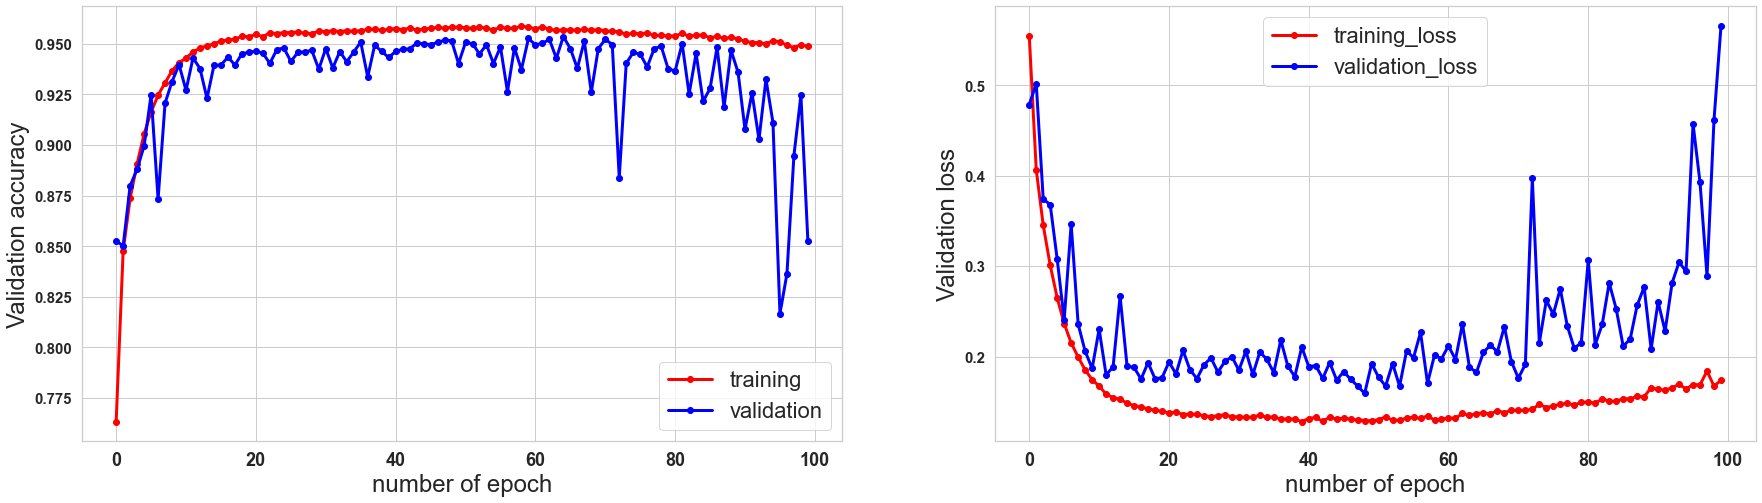

In [ ]:
model_evaluate(GRU_history)

673/673 [==============================] - 13s 19ms/step - loss: 0.1813 - accuracy: 0.9528
loss 0.1812741607427597
Accuracy 0.9528060555458069
Precision 0.9201773908993046
Recall 0.8470051439516982
f1 score 0.8766891941782561


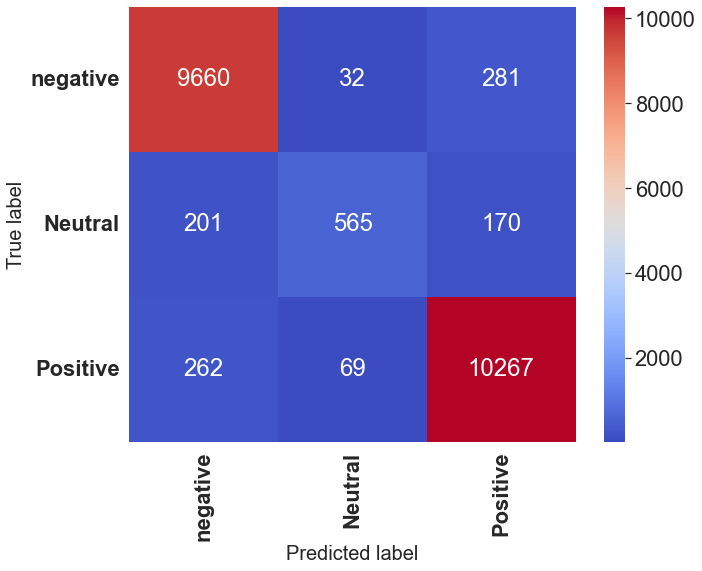

In [ ]:
#make predictions
model = load_model(model_path+"/glove_GRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

,precision,recall,f1-score
negative,95.43,96.86,96.14
Neutral,84.83,60.36,70.54
Positive,95.79,96.88,96.33
accuracy,95.28,95.28,95.28
macro avg,92.02,84.70,87.67
weighted avg,95.15,95.28,95.12


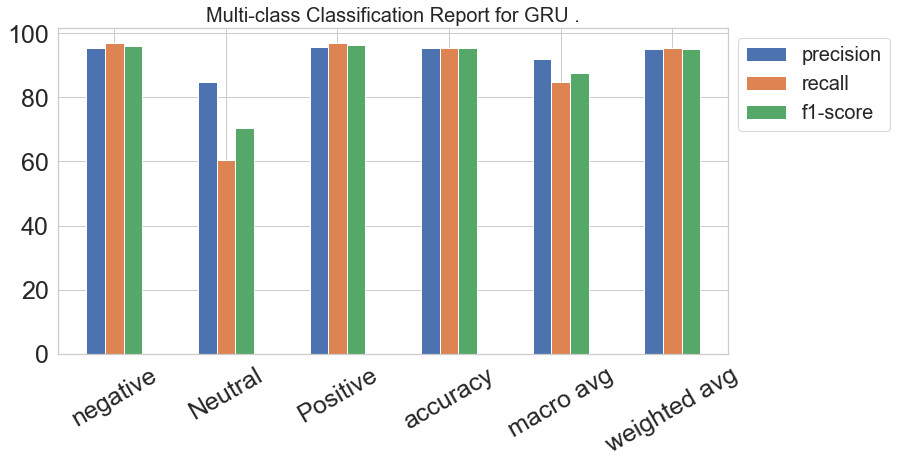

In [ ]:
GRUreport=report_generate(y_pred,"GRU")
GRUreport[1]

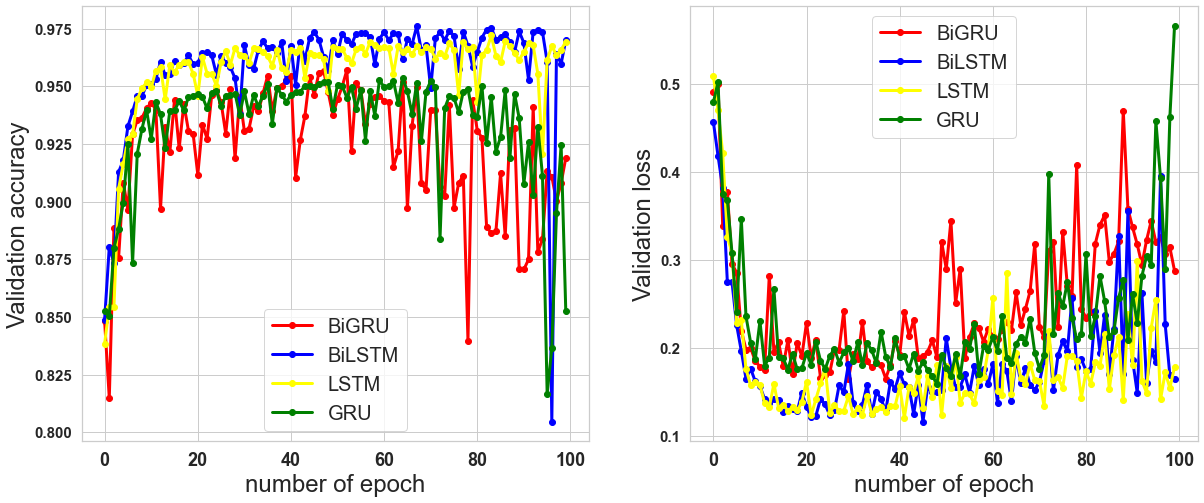

In [ ]:
# Plot all model results
def model_all_evaluate(history1,history2,history3,history4):
  sns.set_style("whitegrid")
  H1 = history1.history
  H2 = history2.history
  H3 = history3.history
  H4 = history4.history
  fig = plt.figure(figsize = (20, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H1['val_accuracy'], label = 'BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_accuracy'], label = 'BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_accuracy'], label = 'LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_accuracy'], label = 'GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H1['val_loss'], label = 'BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_loss'], label = 'BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_loss'], label = 'LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_loss'], label = 'GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})

    
model_all_evaluate(BiGRU_history, BiLSTM_history,LSTM_history, GRU_history )

In [1]:
Bigru = load_model(model_path+"/glove_BiGRU.h5")
Bilstm = load_model(model_path+"/glove_BiLSTM.h5")
lstm = load_model(model_path+"/glove_LSTM.h5")
gru = load_model(model_path+"/glove_GRU.h5")
MLA = {
     'Bidirectional GRU' : Bigru,
     'Bidirectional LSTM' : Bilstm,
     'LSTM' : lstm,
     'GRU' : gru, 
}

columns = []
compare = pd.DataFrame(columns = columns)
# n_classes=4
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    evaluation = alg.evaluate(test_padded,y_test)
    y_pred = alg.predict(test_padded)
    y_pred = np.argmax(predictions, axis=1)
    weighted_averaged_recall = recall_score(y_test, y_pred, average='micro')
    weighted_averaged_precision = precision_score(y_test, y_pred,  average='macro')

    weighted_averaged_f1 = 2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'Accuracy'] = evaluation[1]
    compare.loc[row_index, 'loss'] = evaluation[0]
    compare.loc[row_index, 'Precision'] = weighted_averaged_precision
    compare.loc[row_index, 'Recall'] = weighted_averaged_recall
    compare.loc[row_index, 'F1 Score'] = weighted_averaged_f1
   

    row_index+=1
    
compare.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    
compare

,Name,Accuracy,Loss,Precision,Recall,F1 score
0,Bidirectional LSTM,0.974055,0.197045,0.970122,0.976845,0.974225
1,LSTM,0.972846,0.158942,0.970831,0.956689,0.973475
2,GRU,0.952896,0.181274,0.954615,0.955114,0.954883
3,Bidirectional GRU,0.952171,0.243012,0.948232,0.953244,0.952602
